#Waymo Open Dataset 3D Semantic Segmentation Tutorial

- Website: https://waymo.com/open
- GitHub: https://github.com/waymo-research/waymo-open-dataset

This tutorial demonstrates how to decode and interpret the 3D semantic segmentation labels. Visit the [Waymo Open Dataset Website](https://waymo.com/open) to download the full dataset.

To use, open this notebook in [Colab](https://colab.research.google.com).

Uncheck the box "Reset all runtimes before running" if you run this colab directly from the remote kernel. Alternatively, you can make a copy before trying to run it by following "File > Save copy in Drive ...".



# Package Installation

Package installation
Please follow the instructions in [tutorial.ipynb](https://github.com/waymo-research/waymo-open-dataset/blob/master/tutorial/tutorial.ipynb).

# Imports and global definitions

In [1]:
# Data location. Please edit.

# A tfrecord containing tf.Example protos as downloaded from the Waymo dataset
# webpage.

# Replace this path with your own tfrecords.
# FILENAME = '/content/waymo-od/tutorial/.../tfexample.tfrecord'

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
import os
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
import numpy as np

tf.enable_eager_execution()

from waymo_open_dataset.utils import  frame_utils
from waymo_open_dataset import dataset_pb2 as open_dataset
from waymo_open_dataset.protos import segmentation_metrics_pb2
from waymo_open_dataset.protos import segmentation_submission_pb2

# Read 3D semantic segmentation labels from Frame proto
 Note that only a subset of the frames have 3d semseg labels.

In [3]:
from tqdm import tqdm
FILENAME = '/home/derek/tools/waymo-open-dataset/waymo_format/validation/segment-260994483494315994_2797_545_2817_545_with_camera_labels.tfrecord'
! ls -lh $FILENAME
dataset = tf.data.TFRecordDataset(FILENAME, compression_type='')
for data in tqdm(dataset):
    frame = open_dataset.Frame()
    frame.ParseFromString(bytearray(data.numpy()))
    if frame.lasers[0].ri_return1.segmentation_label_compressed:
      break

-rwxrwxr-x 1 jiajizheng jiajizheng 784M Dec 27 12:12 /home/derek/tools/waymo-open-dataset/waymo_format/validation/segment-260994483494315994_2797_545_2817_545_with_camera_labels.tfrecord


2022-12-29 20:12:16.418503: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-12-29 20:12:16.443210: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: niubi-gpu-server
2022-12-29 20:12:16.443303: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: niubi-gpu-server
2022-12-29 20:12:16.443630: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.86.1
2022-12-29 20:12:16.443738: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.86.1
2022-12-29 20:12:16.443745: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.86.1
2022-12-29 20:12:16.451432: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU 

In [4]:
print(frame.context.name)
print(frame.context.stats)

260994483494315994_2797_545_2817_545
laser_object_counts {
  type: TYPE_VEHICLE
  count: 11
}
laser_object_counts {
  type: TYPE_SIGN
  count: 16
}
time_of_day: "Day"
location: "location_phx"
weather: "sunny"
camera_object_counts {
  type: TYPE_VEHICLE
  count: 52
}
camera_object_counts {
  type: TYPE_PEDESTRIAN
  count: 6
}



In [5]:
(range_images, camera_projections, segmentation_labels,
 range_image_top_pose) = frame_utils.parse_range_image_and_camera_projection(frame)

In [6]:
segmentation_labels[open_dataset.LaserName.TOP][0].shape.dims

[64, 2650, 2]

# Visualize Segmentation Labels in Range Images

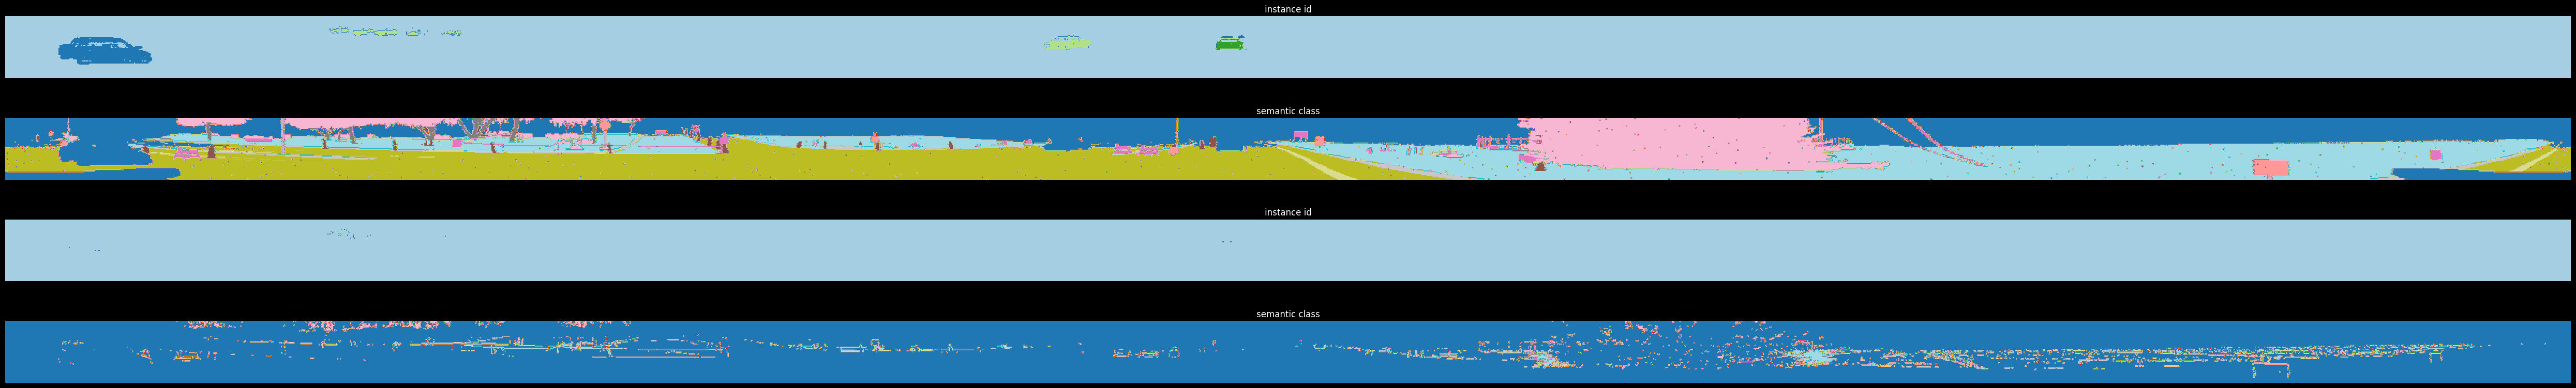

In [47]:
plt.figure(figsize=(64, 20))
def plot_range_image_helper(data, name, layout, vmin = 0, vmax=1, cmap='gray'):
  """Plots range image.

  Args:
    data: range image data
    name: the image title
    layout: plt layout
    vmin: minimum value of the passed data
    vmax: maximum value of the passed data
    cmap: color map
  """
  plt.subplot(*layout)
  plt.imshow(data, cmap=cmap, vmin=vmin, vmax=vmax)
  plt.title(name)
  plt.grid(False)
  plt.axis('off')

def get_semseg_label_image(laser_name, return_index):
  """Returns semseg label image given a laser name and its return index."""
  return segmentation_labels[laser_name][return_index]

def show_semseg_label_image(semseg_label_image, layout_index_start = 1):
  """Shows range image.

  Args:
    show_semseg_label_image: the semseg label data of type MatrixInt32.
    layout_index_start: layout offset
  """
  semseg_label_image_tensor = tf.convert_to_tensor(semseg_label_image.data)
  semseg_label_image_tensor = tf.reshape(
      semseg_label_image_tensor, semseg_label_image.shape.dims)
  # each image has two layers: instance id and semantic class
  instance_id_image = semseg_label_image_tensor[...,0] 
  semantic_class_image = semseg_label_image_tensor[...,1]
  plot_range_image_helper(instance_id_image.numpy(), 'instance id',
                   [8, 1, layout_index_start], vmin=-1, vmax=200, cmap='Paired')
  plot_range_image_helper(semantic_class_image.numpy(), 'semantic class',
                   [8, 1, layout_index_start + 1], vmin=0, vmax=22, cmap='tab20')

frame.lasers.sort(key=lambda laser: laser.name)
label_image_ri1 = get_semseg_label_image(open_dataset.LaserName.TOP, 0)
label_image_ri2 = get_semseg_label_image(open_dataset.LaserName.TOP, 1)
show_semseg_label_image(label_image_ri1, 1)
show_semseg_label_image(label_image_ri2, 3)

# Point Cloud Conversion and Visualization

In [48]:
def convert_range_image_to_point_cloud_labels(frame,
                                              range_images,
                                              segmentation_labels,
                                              ri_index=0):
  """Convert segmentation labels from range images to point clouds.

  Args:
    frame: open dataset frame
    range_images: A dict of {laser_name, [range_image_first_return,
       range_image_second_return]}.
    segmentation_labels: A dict of {laser_name, [range_image_first_return,
       range_image_second_return]}.
    ri_index: 0 for the first return, 1 for the second return.

  Returns:
    point_labels: {[N, 2]} list of 3d lidar points's segmentation labels. 
    0 for points that are not labeled.
  """
  calibrations = sorted(frame.context.laser_calibrations, key=lambda c: c.name)
  point_labels = []
  for c in calibrations:
    range_image = range_images[c.name][ri_index]
    range_image_tensor = tf.reshape(
        tf.convert_to_tensor(range_image.data), range_image.shape.dims)
    range_image_mask = range_image_tensor[..., 0] > 0

    if c.name in segmentation_labels:
      sl = segmentation_labels[c.name][ri_index]
      sl_tensor = tf.reshape(tf.convert_to_tensor(sl.data), sl.shape.dims)
      sl_points_tensor = tf.gather_nd(sl_tensor, tf.where(range_image_mask))
    else:
      num_valid_point = tf.math.reduce_sum(tf.cast(range_image_mask, tf.int32))
      sl_points_tensor = tf.zeros([num_valid_point, 2], dtype=tf.int32)
      
    point_labels.append(sl_points_tensor.numpy())
  return point_labels


point_labels = convert_range_image_to_point_cloud_labels(
    frame, range_images, segmentation_labels)


[23:12:21] WARNING  Tensor._shape is private, use Tensor.shape        ops.py:474
                    instead. Tensor._shape will eventually be                   
                    removed.                                                    
[23:13:16] WARNING  Tensor._shape is private, use Tensor.shape        ops.py:474
                    instead. Tensor._shape will eventually be                   
                    removed.                                                    
[23:13:25] WARNING  Tensor._shape is private, use Tensor.shape        ops.py:474
                    instead. Tensor._shape will eventually be                   
                    removed.                                                    


In [9]:
points, cp_points = frame_utils.convert_range_image_to_point_cloud(
    frame, range_images, camera_projections, range_image_top_pose)
points_ri2, cp_points_ri2 = frame_utils.convert_range_image_to_point_cloud(
    frame, range_images, camera_projections, range_image_top_pose, ri_index=1)

In [36]:
point_labels = convert_range_image_to_point_cloud_labels(
    frame, range_images, segmentation_labels)
point_labels_ri2 = convert_range_image_to_point_cloud_labels(
    frame, range_images, segmentation_labels, ri_index=1)

In [11]:
# 3d points in vehicle frame.
points_all = np.concatenate(points, axis=0)
points_all_ri2 = np.concatenate(points_ri2, axis=0)
# point labels.
point_labels_all = np.concatenate(point_labels, axis=0)
point_labels_all_ri2 = np.concatenate(point_labels_ri2, axis=0)
# camera projection corresponding to each point.
cp_points_all = np.concatenate(cp_points, axis=0)
cp_points_all_ri2 = np.concatenate(cp_points_ri2, axis=0)
'''
points_all: (129605, 3)
points_all_ri2: (7362, 3)
point_labels_all: (129605, 2)
point_labels_all_ri2: (7362, 2)
cp_points_all: (129605, 6)
cp_points_all_ri2: (7362, 6)
'''

'\npoints_all: (129605, 3)\npoints_all_ri2: (7362, 3)\npoint_labels_all: (129605, 2)\npoint_labels_all_ri2: (7362, 2)\ncp_points_all: (129605, 6)\ncp_points_all_ri2: (7362, 6)\n'

In [64]:
max_i = 100
last_a = -1
for i, (a, b) in enumerate(point_labels_all):
    if b==0 and a!=0 and a!=last_a:
        last_a = a
        print(i, a, b)

In [68]:
import pandas as pd
print('semantic id:')
print(pd.Series(point_labels_all[:,1]).value_counts().sort_index())

semantic id:
0     15117
1      3066
8       958
10      464
11      925
14     2555
15    19766
16     1029
17     2754
18    41313
19      949
21    39852
22      857
dtype: int64


In [70]:
point_labels_all_df = pd.DataFrame(point_labels_all, columns=['instance', 'semantic'])
point_labels_all_df.query('instance>0').semantic.value_counts()

1    3066
Name: semantic, dtype: int64

### Show colored point cloud
Example of rendered point clouds (this tutorial does not have visualization capability).

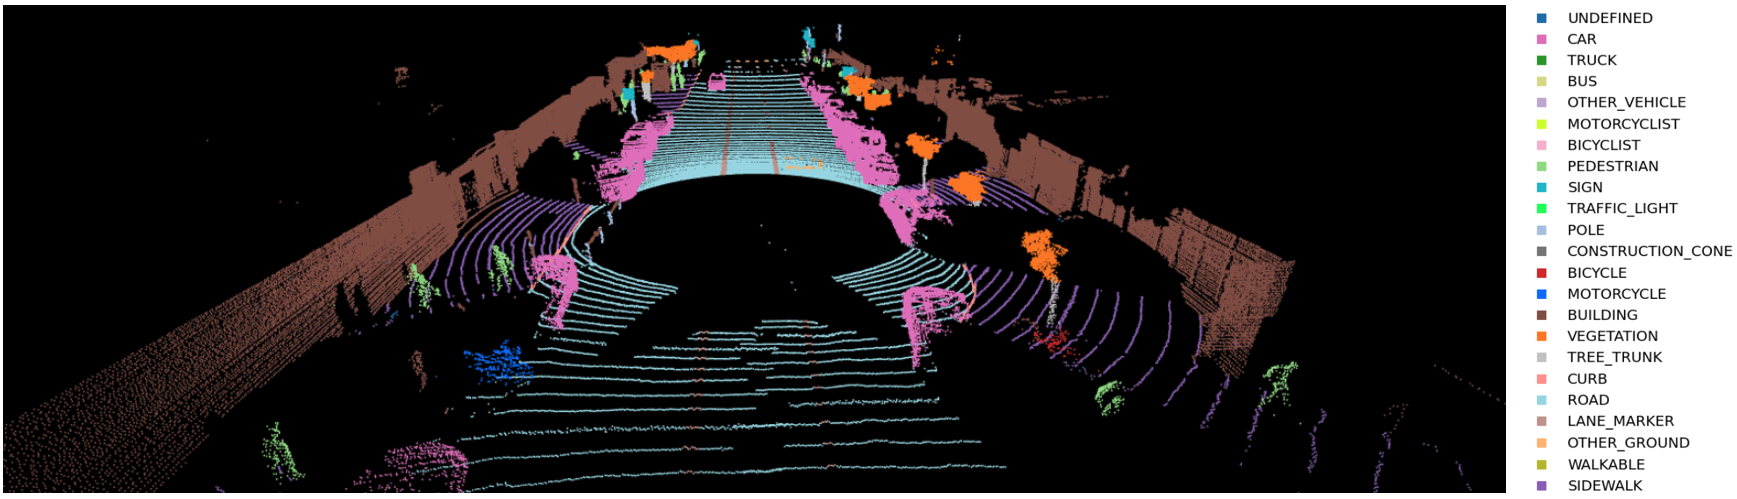

In [12]:
from IPython.display import Image, display
display(Image('tutorial/3d_semseg_points.png'))

# Create a dummy submission file for the validation set

In [13]:
import zlib

def compress_array(array: np.ndarray, is_int32: bool = False):
  """Compress a numpy array to ZLIP compressed serialized MatrixFloat/Int32.

  Args:
    array: A numpy array.
    is_int32: If true, use MatrixInt32, otherwise use MatrixFloat.

  Returns:
    The compressed bytes.
  """
  if is_int32:
    m = open_dataset.MatrixInt32()
  else:
    m = open_dataset.MatrixFloat()
  m.shape.dims.extend(list(array.shape))
  m.data.extend(array.reshape([-1]).tolist())
  return zlib.compress(m.SerializeToString())

def decompress_array(array_compressed: bytes, is_int32: bool = False):
  """Decompress bytes (of serialized MatrixFloat/Int32) to a numpy array.

  Args:
    array_compressed: bytes.
    is_int32: If true, use MatrixInt32, otherwise use MatrixFloat.

  Returns:
    The decompressed numpy array.
  """
  decompressed = zlib.decompress(array_compressed)
  if is_int32:
    m = open_dataset.MatrixInt32()
    dtype = np.int32
  else:
    m = open_dataset.MatrixFloat()
    dtype = np.float32
  m.ParseFromString(decompressed)
  return np.array(m.data, dtype=dtype).reshape(m.shape.dims)

In [14]:
TOP_LIDAR_ROW_NUM = 64
TOP_LIDAR_COL_NUM = 2650

In [15]:
def get_range_image_point_indexing(range_images, ri_index=0):
  """Get the indices of the valid points (of the TOP lidar) in the range image.

  The order of the points match those from convert_range_image_to_point_cloud
  and convert_range_image_to_point_cloud_labels.

  Args:
    range_images: A dict of {laser_name, [range_image_first_return,
       range_image_second_return]}.
    ri_index: 0 for the first return, 1 for the second return.

  Returns:
    points_indexing_top: (N, 2) col and row indices of the points in the
      TOP lidar.
  """
  points_indexing_top = None
  xgrid, ygrid = np.meshgrid(range(TOP_LIDAR_COL_NUM), range(TOP_LIDAR_ROW_NUM))
  col_row_inds_top = np.stack([xgrid, ygrid], axis=-1)
  range_image = range_images[open_dataset.LaserName.TOP][ri_index]
  range_image_tensor = tf.reshape(
      tf.convert_to_tensor(range_image.data), range_image.shape.dims)
  range_image_mask = range_image_tensor[..., 0] > 0
  points_indexing_top = col_row_inds_top[np.where(range_image_mask)]
  return points_indexing_top

In [16]:
def dummy_semseg_for_one_frame(frame, dummy_class=14):
  """Assign all valid points to a single dummy class.

  Args:
    frame: An Open Dataset Frame proto.
    dummy_class: The class to assign to. Default is 14 (building).

  Returns:
    segmentation_frame: A SegmentationFrame proto.
  """
  (range_images, camera_projections, segmentation_labels,
   range_image_top_pose) = frame_utils.parse_range_image_and_camera_projection(
       frame)
  # Get the col, row indices of the valid points.
  points_indexing_top = get_range_image_point_indexing(range_images, ri_index=0)
  points_indexing_top_ri2 = get_range_image_point_indexing(
      range_images, ri_index=1)
  # Assign the dummy class to all valid points (in the range image)
  range_image_pred = np.zeros(
      (TOP_LIDAR_ROW_NUM, TOP_LIDAR_COL_NUM, 2), dtype=np.int32)
  range_image_pred[points_indexing_top[:, 1],
                   points_indexing_top[:, 0], 1] = dummy_class
  range_image_pred_ri2 = np.zeros(
      (TOP_LIDAR_ROW_NUM, TOP_LIDAR_COL_NUM, 2), dtype=np.int32)
  range_image_pred_ri2[points_indexing_top_ri2[:, 1],
                       points_indexing_top_ri2[:, 0], 1] = dummy_class
  # Construct the SegmentationFrame proto.
  segmentation_frame = segmentation_metrics_pb2.SegmentationFrame()
  segmentation_frame.context_name = frame.context.name
  segmentation_frame.frame_timestamp_micros = frame.timestamp_micros
  laser_semseg = open_dataset.Laser()
  laser_semseg.name = open_dataset.LaserName.TOP
  laser_semseg.ri_return1.segmentation_label_compressed = compress_array(
      range_image_pred, is_int32=True)
  laser_semseg.ri_return2.segmentation_label_compressed = compress_array(
      range_image_pred_ri2, is_int32=True)
  segmentation_frame.segmentation_labels.append(laser_semseg)
  return segmentation_frame

In [17]:
# Create the dummy pred file for the validation set run segments.

# Replace this path with the real path to the WOD validation set folder.
folder_name = 'waymo_format/validation/'

filenames = [os.path.join(folder_name, x) for x in os.listdir(
    folder_name) if 'tfrecord' in x]
assert(len(filenames) == 202)

segmentation_frame_list = segmentation_metrics_pb2.SegmentationFrameList()
for idx, filename in enumerate(filenames):
  if idx % 10 == 0:
    print('Processing %d/%d run segments...' % (idx, len(filenames)))
  dataset = tf.data.TFRecordDataset(filename, compression_type='')
  for data in dataset:
    frame = open_dataset.Frame()
    frame.ParseFromString(bytearray(data.numpy()))
    if frame.lasers[0].ri_return1.segmentation_label_compressed:
      segmentation_frame = dummy_semseg_for_one_frame(frame)
      segmentation_frame_list.frames.append(segmentation_frame)
print('Total number of frames: ', len(segmentation_frame_list.frames))

Processing 0/202 run segments...


KeyboardInterrupt: 

In [ ]:
# Create the submission file, which can be uploaded to the eval server.
submission = segmentation_submission_pb2.SemanticSegmentationSubmission()
submission.account_name = 'joe@gmail.com'
submission.unique_method_name = 'JoeNet'
submission.affiliation = 'Smith Inc.'
submission.authors.append('Joe Smith')
submission.description = "A dummy method by Joe (val set)."
submission.method_link = 'NA'
submission.sensor_type = 1
submission.number_past_frames_exclude_current = 2
submission.number_future_frames_exclude_current = 0
submission.inference_results.CopyFrom(segmentation_frame_list)

In [ ]:
output_filename = '/tmp/wod_semseg_val_set_dummy_pred_submission.bin'
f = open(output_filename, 'wb')
f.write(submission.SerializeToString())
f.close()

# Create a dummy submission file for the testing set

In [ ]:
# Create the dummy pred file for the testing set run segments.

# Replace the paths with the real paths to the WOD testing set folders.
folder_name1 = '/content/waymo-od/.../testing/'
folder_name2 = '/content/waymo-od/.../testing_location/'
filenames1 = [os.path.join(folder_name1, x) for x in os.listdir(
    folder_name1) if 'tfrecord' in x]
filenames2 = [os.path.join(folder_name2, x) for x in os.listdir(
    folder_name2) if 'tfrecord' in x]
filenames = filenames1 + filenames2
print(len(filenames))
assert(len(filenames) == 150)

# Replace this path with the real path. The file is under:
# /waymo-open-dataset/tutorial/ in the github repo.
# Each line of the file is the "<context_name>, <timestamp_micros>" of a frame
# with semseg labels. 
testing_set_frame_file = '/path/3d_semseg_test_set_frames.txt'
context_name_timestamp_tuples = [x.rstrip().split(',') for x in (
    open(testing_set_frame_file, 'r').readlines())]

segmentation_frame_list = segmentation_metrics_pb2.SegmentationFrameList()
for idx, filename in enumerate(filenames):
  if idx % 10 == 0:
    print('Processing %d/%d run segments...' % (idx, len(filenames)))
  dataset = tf.data.TFRecordDataset(filename, compression_type='')
  for data in dataset:
    frame = open_dataset.Frame()
    frame.ParseFromString(bytearray(data.numpy()))
    context_name = frame.context.name
    timestamp = frame.timestamp_micros
    if (context_name, str(timestamp)) in context_name_timestamp_tuples:
      print(context_name, timestamp)
      segmentation_frame = dummy_semseg_for_one_frame(frame)
      segmentation_frame_list.frames.append(segmentation_frame)
print('Total number of frames: ', len(segmentation_frame_list.frames))

FileNotFoundError: [Errno 2] No such file or directory: '/content/waymo-od/.../testing/'

In [ ]:
# Create the submission file, which can be uploaded to the eval server.
submission = segmentation_submission_pb2.SemanticSegmentationSubmission()
submission.account_name = 'joe@gmail.com'
submission.unique_method_name = 'JoeNet'
submission.affiliation = 'Smith Inc.'
submission.authors.append('Joe Smith')
submission.description = "A dummy method by Joe (test set)."
submission.method_link = 'NA'
submission.sensor_type = 1
submission.number_past_frames_exclude_current = 2
submission.number_future_frames_exclude_current = 0
submission.inference_results.CopyFrom(segmentation_frame_list)

: 

In [ ]:
output_filename = '/tmp/wod_semseg_test_set_dummy_pred_submission.bin'
f = open(output_filename, 'wb')
f.write(submission.SerializeToString())
f.close()

: 